In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Part 1

## Question 4

In [203]:
def update_value(index_to_v_t_map, s, a, reward_func, actions_matrices):
    states = index_to_v_t_map.index
    l_side = reward_func(s, a)
    r_side = 0
    for s_tag in states:
        r_side += actions_matrices[a].loc[s_tag, s] * \
            index_to_v_t_map.loc[s_tag, "v_t"]
    return l_side + r_side


def value_iteration(actions_matrices, reward_func, init_index_to_v_t_map, epsilon=np.exp(-10), max_T=5000):

    actions = list(actions_matrices.keys())
    index_to_v_t_map = init_index_to_v_t_map.copy()
    last_opt = index_to_v_t_map["v_t"]
    opt = np.repeat(np.inf, init_index_to_v_t_map.shape[0])
    t = 0

    while ((opt - last_opt) > epsilon).any() and (t < max_T):
        for a in actions:
            index_to_v_t_map[a] = index_to_v_t_map.apply(lambda row:
                                                         update_value(index_to_v_t_map, row.name, a, reward_func, actions_matrices), axis=1)

        opt = index_to_v_t_map[actions].max(axis=1)
        index_to_v_t_map["policy"] = index_to_v_t_map[actions].idxmax(axis=1)
        last_opt = index_to_v_t_map["v_t"]
        index_to_v_t_map["v_t"] = opt
        t += 1

    return index_to_v_t_map


In [204]:
init_index_to_v_t_map = pd.DataFrame(0, index=list("HO"), columns=["v_t"])


def reward_home_out(s, a):
    if s == "H":
        if a == "STAY":
            return 0
        else:
            return 1
    else:
        if a == "STAY":
            return 2
        else:
            return 0


actions_matrices_home_out = {
    "STAY": pd.DataFrame(np.array([[1, 0], [0, 1]]), index=list("HO"), columns=list("HO")),
    "SWITCH": pd.DataFrame(np.array([[0.2, 1], [0.8, 0]]), index=list("HO"), columns=list("HO"))
}


In [205]:
result = value_iteration(actions_matrices=actions_matrices_home_out,
                         reward_func=reward_home_out,
                         init_index_to_v_t_map=init_index_to_v_t_map)
result[["v_t", "policy"]].rename(columns={"v_t": "v*", "policy": "\u03C0*"})


,v*,π*
H,2.8,SWITCH
O,4.0,STAY


המדיניות האופטימלית שנמצאה זהה לזאת שבשאלה 2

# Part 2

## Question 1

In [206]:
def next_s(s, a, reward_function, actions_matrices):
    s_next = np.random.choice(
        actions_matrices[a][s].index, p=actions_matrices[a][s].values)
    r = reward_function(s, a)
    return s_next, r


## Question 2

In [219]:
ETA = 0.01
GAMMA = 0.5
T = 3000
s = "H"
v_map = init_index_to_v_t_map.rename(columns={"v_t": 0}) 
actions = ["STAY", "SWITCH"]


In [220]:
for t in range(1, T):
    v_map[t] = np.nan
    act = np.random.choice(actions, p=[0.5, 0.5])
    s_tag, r = next_s(s, act, reward_home_out, actions_matrices_home_out)
    v_map.loc[s, t] = v_map.loc[s, t - 1] + ETA * \
        (reward_home_out(s, act) + GAMMA *
         v_map.loc[s_tag, t-1] - v_map.loc[s, t - 1])

    if s_tag != s:
        v_map.loc[s_tag, t] = v_map.loc[s_tag, t - 1]
        s = s_tag
    else:
        other_s = v_map.index.difference(pd.Index([s]))[0]
        v_map.loc[other_s, t] = v_map.loc[other_s, t - 1]


C:\Users\T-NWEI~1\AppData\Local\Temp/ipykernel_36148/1433220520.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  v_map[t] = np.nan


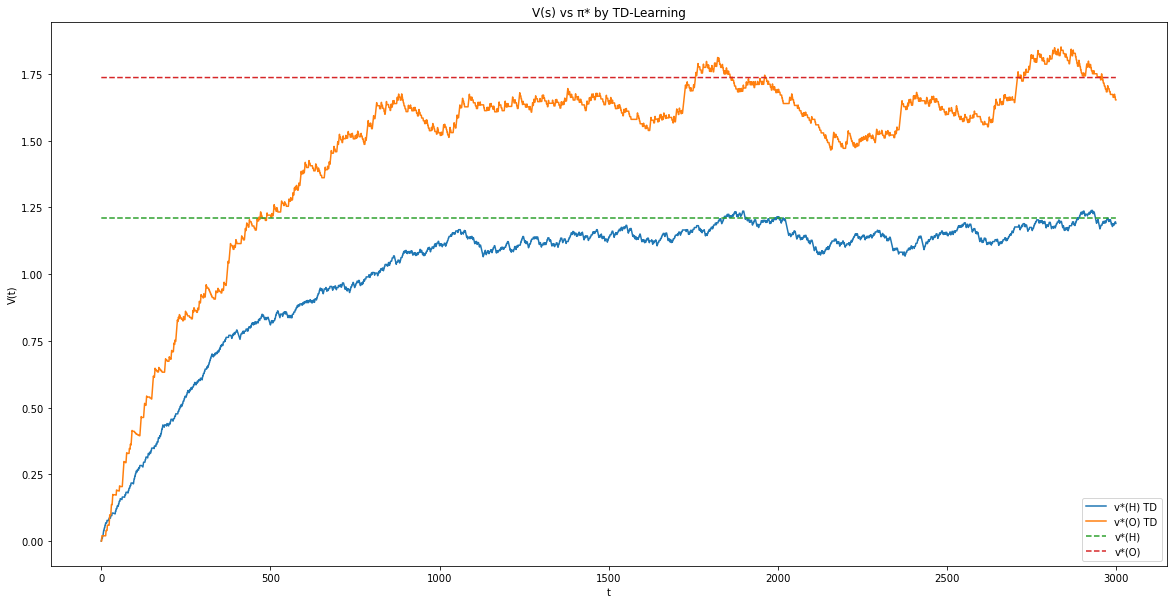

In [221]:
v_map.transpose().rename(
    columns={"H": 'v*(H) TD', "O": 'v*(O) TD'}).plot(figsize=(20, 10))
plt.title("V(s) vs \u03C0* by TD-Learning")
plt.xlabel("t")
plt.ylabel("V(t)")
plt.plot(np.arange(T), np.repeat(1.21, T),
         linestyle="--", label='v*(H)')
plt.plot(np.arange(T), np.repeat(1.736, T),
         linestyle="--", label='v*(O)')
plt.legend()
plt.show()


הלמידה מתכנסת לערכים האופטימלים הנכונים. אפשר לראות לפי השיפוע בערך 800.
ניתן לראות כי עלייך בקצב הלמידה גורמת לאלגוריתם להתכנס מהר יותר אך גם יוצרת שונות גבוהה סביב ערך האמת לאחר ההתכנסות.
אך מצד שני קצב למידה נמוך גורמים לאלגוריתם להתכנס לאט יותר ולהקטין את השונות סביב ערך האמת לאחר ההתכנסות

## Question 3

In [222]:
ETA = 0.1
states = ["H", "O"]
Q = pd.DataFrame(0, index=["H_STAY", "H_SWITCH", "O_STAY", "O_SWITCH"],
                 columns=[0])
V_s = pd.DataFrame(np.nan, index=np.arange(T), columns=states)


In [223]:
for t in range(1, T):
    for s in states:
        for a in actions:
            s_tag, r = next_s(s, a, reward_home_out, actions_matrices_home_out)
            d = r + GAMMA * Q.loc[Q.index.str.startswith(s_tag), t - 1].max() - \
                Q.loc[s + "_" + a, t - 1]
            Q.loc[s + "_" + a, t] = Q.loc[s + "_" + a, t - 1] + ETA * d
        V_s.loc[t, s] = Q.loc[Q.index.str.startswith(s), t].max()


C:\Users\t-nweisler\Anaconda3\lib\site-packages\pandas\core\indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


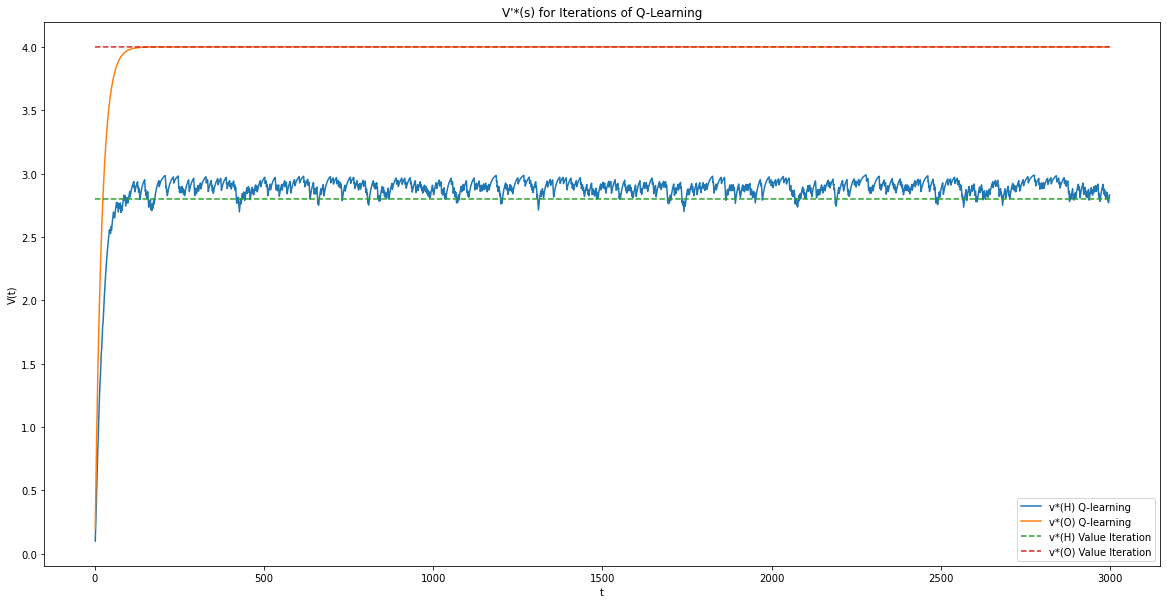

In [224]:
V_s.rename(columns={"H": 'v*(H) Q-learning',
           "O": 'v*(O) Q-learning'}).plot(figsize=(20, 10))
plt.plot(np.arange(T), np.repeat(
    result.loc["H", "v_t"], T), linestyle="--", label='v*(H) Value Iteration')
plt.plot(np.arange(T), np.repeat(
    result.loc["O", "v_t"], T), linestyle="--", label='v*(O) Value Iteration')
plt.title("V'*(s) for Iterations of Q-Learning")
plt.xlabel("t")
plt.ylabel("V(t)")
plt.legend()
plt.show()


הערכים התכנסו לערכים האופטימלים בהתאם לחלק הראשון של השאלה הרביעית.
לפי הארחים האופטימלים נוכל להסיק את המדיניות האופטימלית בעזרת משוואת האופטימליות של בלמן, זאת בגלל ששאר הפרמטרים ידועים לנו ועלינו רק למקסם את הפעולות.
ניתן לראות שהשונות לאחר התכנסות 

V(O)

היא 0 אך ל

V(H)

יש מעט שונות
הסיבה עלויה להיות ההבדלים בין הסתברויות המעבר של שני המצבים, בהינתן פעולה ספציפית נקבע המאבר ממצב 'אאוט' בעוד שקיימת אקראיות מסויימת במעבר ממצב 

stay

למצב

switch
